<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Accumulate_Classweight_DenseNet121_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [0]:
!nvidia-smi

Thu May 28 20:35:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Run:AI Gradient Accumulation library
https://github.com/run-ai/runai/tree/master/runai/ga

In [0]:
!pip install runai

# Import Libraries

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.legacy import interfaces
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import runai.ga.keras

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 16
STEPS = 16
LR = 1e-4
EPOCHS = 100

# Data Preparation

In [0]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

fatal: destination path 'ham10000-with-one-image-folder' already exists and is not an empty directory.


In [0]:
metadata_path = '/content/ham10000-with-one-image-folder/HAM10000_metadata.csv'
img_path = '/content/ham10000-with-one-image-folder/HAM1000_images'

In [0]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
data = pd.read_csv(metadata_path)

In [0]:
num_examples = data.values.shape[0]

In [0]:
inputs = np.empty(shape=(num_examples, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

## Resize to 224*224

In [0]:
for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    all_img_path = os.path.join(img_path, img_id) + '.jpg' 
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    else:
        raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

## Split Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=555)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=555)

In [0]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


## Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

In [0]:
datagen.fit(x_train)

# Adam Accumulate

In [0]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [28-05-2020 20:37:59.093] [1158] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Build Model
DenseNet121 + fine tuning

In [0]:
def build_model():
  base_model = DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(average_pooling_layer)
  fc_layer = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(fc_layer)
  fc_layer = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(fc_layer)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(fc_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  model.compile(optimizer=ga_optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
model = build_model()

In [0]:
# model.summary()

## Class Weights

### Train set

In [0]:
train_class_weight = compute_class_weight('balanced', np.unique(y_train), y_train)

In [0]:
print(train_class_weight)

[ 4.29183673  2.70656371  1.25527258 11.12698413  1.28571429  0.21587682
  9.90423862]


In [0]:
train_class_weight_dict = { i : train_class_weight[i] for i in range(0, len(train_class_weight) ) }

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='acc_densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-5, mode='min')

## Training

In [0]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=train_class_weight_dict,
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=[early_stop, model_checkpoint, reduce_lr_rate])


Epoch 1/100
395/395 [==============================] - 101s 256ms/step - loss: 15.1284 - accuracy: 0.2324 - val_loss: 14.5420 - val_accuracy: 0.3066
Epoch 2/100
395/395 [==============================] - 73s 186ms/step - loss: 14.2898 - accuracy: 0.3202 - val_loss: 13.8924 - val_accuracy: 0.3118
Epoch 3/100
395/395 [==============================] - 73s 186ms/step - loss: 13.6814 - accuracy: 0.3455 - val_loss: 13.2418 - val_accuracy: 0.3964
Epoch 4/100
395/395 [==============================] - 74s 187ms/step - loss: 13.0830 - accuracy: 0.3703 - val_loss: 12.7128 - val_accuracy: 0.4149
Epoch 5/100
395/395 [==============================] - 74s 186ms/step - loss: 12.5636 - accuracy: 0.3590 - val_loss: 12.2147 - val_accuracy: 0.3798
Epoch 6/100
395/395 [==============================] - 74s 186ms/step - loss: 12.0873 - accuracy: 0.3639 - val_loss: 11.7435 - val_accuracy: 0.4246
Epoch 7/100
395/395 [==============================] - 73s 185ms/step - loss: 11.6385 - accuracy: 0.3799 - val

# Graph

## Accuracy

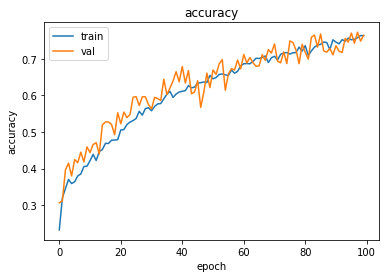

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

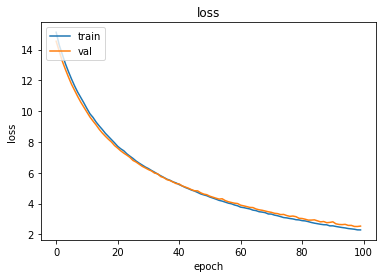

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = load_model('/content/acc_densenet121_model.h5', compile=False)

In [0]:
y_pred = np.argmax(test_model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.7512828676921013


## Classification Report

In [0]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.53      0.58      0.55        33
         bcc       0.64      0.78      0.70        41
         bkl       0.60      0.65      0.62        99
          df       0.41      0.85      0.55        13
         mel       0.40      0.76      0.53       118
          nv       0.97      0.77      0.85       681
        vasc       0.75      0.88      0.81        17

    accuracy                           0.75      1002
   macro avg       0.61      0.75      0.66      1002
weighted avg       0.83      0.75      0.77      1002



## Confusion Matrix

Confusion matrix, without normalization
[[ 19   3   5   1   4   1   0]
 [  5  32   1   0   2   0   1]
 [  2   3  64   2  22   6   0]
 [  0   0   0  11   2   0   0]
 [  6   2   8   1  90  11   0]
 [  4  10  28  12 102 521   4]
 [  0   0   1   0   1   0  15]]


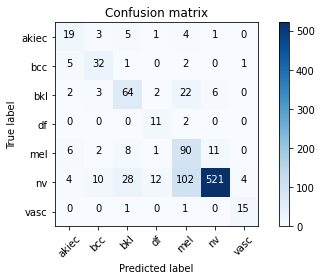

In [0]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

## Sensitivity & Specificity

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [0]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.8636
specificity: 0.8649


# Grad-CAM

In [0]:
last_conv2d = 'conv5_block16_2_conv'

## AKIEC

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.898
	nv             	(5)	with probability 0.054
	bkl            	(2)	with probability 0.015
	akiec          	(0)	with probability 0.010
	df             	(3)	with probability 0.009
Explanation for 'mel'


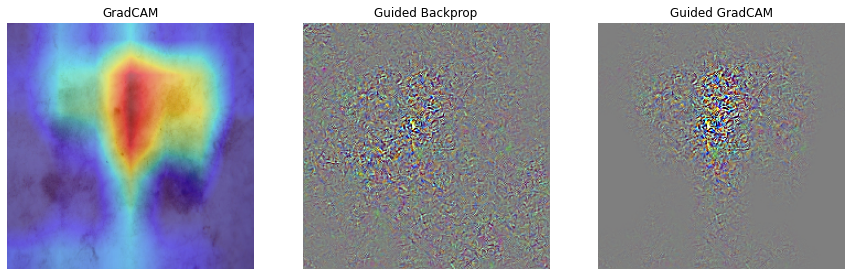

In [0]:
radcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

## BCC

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.510
	bcc            	(1)	with probability 0.358
	vasc           	(6)	with probability 0.053
	bkl            	(2)	with probability 0.029
	mel            	(4)	with probability 0.018
Explanation for 'nv'


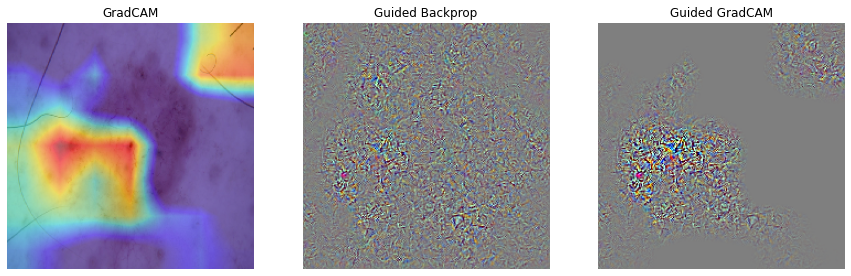

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.685
	bkl            	(2)	with probability 0.136
	nv             	(5)	with probability 0.111
	vasc           	(6)	with probability 0.025
	df             	(3)	with probability 0.024
Explanation for 'mel'


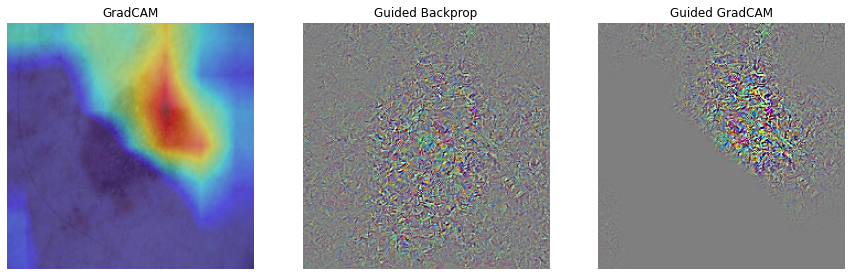

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	nv             	(5)	with probability 0.625
	mel            	(4)	with probability 0.251
	df             	(3)	with probability 0.053
	bkl            	(2)	with probability 0.027
	vasc           	(6)	with probability 0.024
Explanation for 'nv'


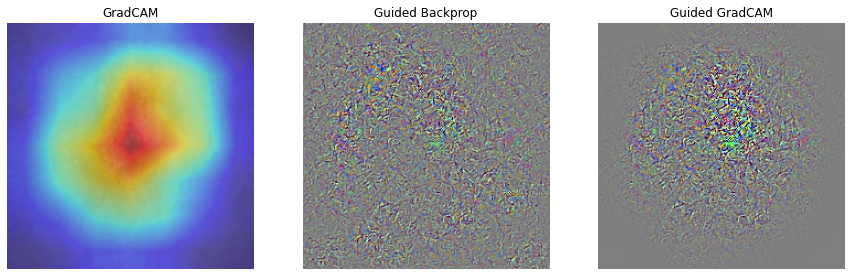

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.624
	nv             	(5)	with probability 0.261
	bkl            	(2)	with probability 0.041
	vasc           	(6)	with probability 0.023
	akiec          	(0)	with probability 0.019
Explanation for 'mel'


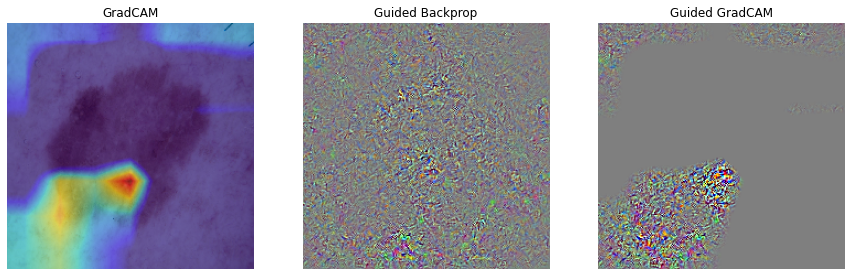

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.686
	vasc           	(6)	with probability 0.138
	mel            	(4)	with probability 0.101
	bkl            	(2)	with probability 0.034
	bcc            	(1)	with probability 0.016
Explanation for 'nv'


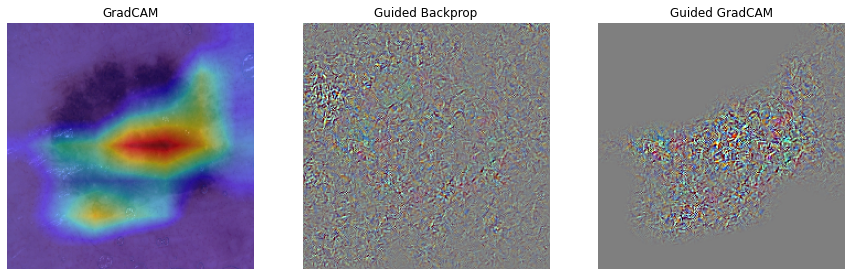

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 1.000
	akiec          	(0)	with probability 0.000
	nv             	(5)	with probability 0.000
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'vasc'


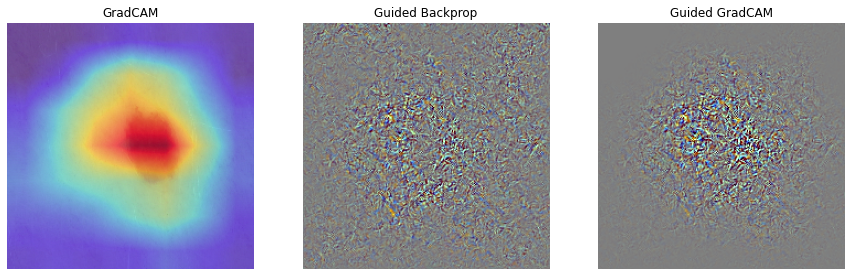

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# Download Model

In [0]:
from google.colab import files

In [0]:
files.download('/content/acc_densenet121_model.h5')

MessageError: ignored